# Automathon 2024

## Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision.io as io
import os
import json
from tqdm import tqdm
import csv
import timm
import wandb

from PIL import Image
import torchvision.transforms as transforms

In [2]:
def get_best_device():
    if torch.cuda.is_available():
        # move models to GPU
        device = torch.device("cuda")
        print('CUDA GPU available for training. Models moved to CUDA GPU')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print('MPS GPU available for training. Models moved to MPS GPU')
    else:
        device = torch.device("cpu")
        print('Training on CPU')
    return device

## Utilities

In [54]:
import matplotlib.pyplot as plt

def display_image(img):
    img = img.permute(1, 2, 0)
    plt.imshow(img)

def smart_resize(data, size): # kudos louis
    """ Prends un tensor de shape [...,C,H,W] et le resize en [C,new_height,new_width]
    """

    full_height = data.shape[-2]
    full_width = data.shape[-1]

    if full_height > full_width:
        alt_height = size
        alt_width = int(full_width * full_height / size)
    elif full_height < full_width:
        alt_height = int(full_height * full_width / size)
        alt_width = size
    else:
        alt_height = size
        alt_width = size
    tr = transforms.Compose([
        transforms.Resize((alt_height, alt_width)),
        transforms.CenterCrop(size)
    ])
    return tr(data)

def resize_data(data, new_height, new_width, x=0, y=0, height=None, width=None):
    """
    Prends un tensor de shape [...,C,H,W] et le resize en [C,new_height,new_width]
    # x, y, height et width servent a faire un crop avant de resize
    """
    
    full_height = data.shape[-2]
    full_width = data.shape[-1]
    height = full_height - y if height is None else height
    width = full_width -x if width is None else width

    ratio = new_height/new_width
    if height/width > ratio:
        expand_height = height
        expand_width = int(height / ratio)
    elif height/width < ratio:
        expand_height = int(width * ratio)
        expand_width = width
    else:
        expand_height = height
        expand_width = width
    tr = transforms.Compose([
        transforms.CenterCrop((expand_height, expand_width)),
        transforms.Resize((new_height, new_width))
    ])
    x = data[...,y:min(y+height, full_height), x:min(x+width, full_width)].clone()
    return tr(x)

## Setup du Dataset

In [77]:
#dataset_dir = "/raid/datasets/hackathon2024"
dataset_dir = "/Users/me/Dropbox (Compte personnel)/Perso NG/Cours et Mooc/_Hackathon/automathon-2024/data"
#root_dir = os.path.expanduser("/kaggle/input/automathon-deepfake/dataset/experimental_dataset")

nb_frames = 10

class VideoDataset(Dataset):
    """
    This Dataset takes a video and returns a tensor of shape [10, 3, 256, 256]
    That is 10 colored frames of 256x256 pixels.
    """
    def __init__(self, root_dir, dataset_choice="train", nb_frames=10, mp4=True):
        super().__init__()
        self.mp4 = mp4

        _to_pt = lambda f: f[:-3] + "pt"

        self.dataset_choice = dataset_choice
        if  self.dataset_choice == "train":
            self.root_dir = os.path.join(root_dir, "train_dataset")
        elif  self.dataset_choice == "test":
            self.root_dir = os.path.join(root_dir, "test_dataset")
        elif  self.dataset_choice == "experimental":
            self.root_dir = os.path.join(root_dir, "experimental_dataset")
        else:
            raise ValueError("choice must be 'train', 'test' or 'experimental'")

        print(self.root_dir)
        
        with open(os.path.join(root_dir, "dataset.csv"), 'r') as file:
            reader = csv.reader(file)
            # read dataset.csv with id,label columns to create
            # a dict which associated label: id
            if mp4:
                self.ids = {row[1]: row[0] for row in reader}
            else:
                self.ids = {_to_pt(row[1]) : row[0] for row in reader}

        if self.dataset_choice == "test":
            self.data = None
        else:
            with open(os.path.join(self.root_dir, "metadata.json"), 'r') as file:
                self.data= json.load(file)
                if mp4:
                    self.data = {k: (torch.tensor(float(1)) if v.upper() == 'FAKE' else torch.tensor(float(0))) for k, v in self.data.items()}
                else:
                    self.data = {_to_pt(k): (torch.tensor(float(1)) if v.upper() == 'FAKE' else torch.tensor(float(0))) for k, v in self.data.items()}

        if mp4:
            self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.mp4')]
        else:
            self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.pt')]

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])

        if self.mp4:
            video, audio, info = io.read_video(video_path, pts_unit='sec')
            video = video.permute(0, 3, 1, 2)
            length = video.shape[0]
            video = video[[i*(length//nb_frames) for i in range(nb_frames)]]
        else:
            video = torch.load(video_path)
        
        print(video.size())
        """
            video = video.permute(0,3,1,2)
            length = video.shape[0]
            video = video[[i*(length//(nb_frames)) for i in range(nb_frames)]]
        """

        # resize the data into a reglar shape of 256x256 and normalize it
        if self.mp4:
            crop_size = 256
            video_s = torch.zeros_like(torch.empty(video.size(0), video.size(1), crop_size, crop_size))
            for i in range(video.size(0)):
                resized = smart_resize(video[i], min(video.size(2), video.size(3)))
                video_s[i, :, :, :] = smart_resize(resized, crop_size)
            video = video_s
            #video = smart_resize(video, crop_size)
        video = video / 255

        ID = self.ids[self.video_files[idx]]

        if self.dataset_choice == "test":
            return video, ID
        else:
            label = self.data[self.video_files[idx]]
            return video, label, ID


train_dataset = VideoDataset(dataset_dir, dataset_choice="train", nb_frames=nb_frames)
#test_dataset = VideoDataset(dataset_dir, dataset_choice="test", nb_frames=nb_frames)
experimental_dataset = VideoDataset(dataset_dir, dataset_choice="experimental", nb_frames=nb_frames)


/Users/me/Dropbox (Compte personnel)/Perso NG/Cours et Mooc/_Hackathon/automathon-2024/data/train_dataset
/Users/me/Dropbox (Compte personnel)/Perso NG/Cours et Mooc/_Hackathon/automathon-2024/data/experimental_dataset


torch.Size([10, 3, 1080, 1920])
tensor(0.)
torch.Size([10, 3, 256, 256])


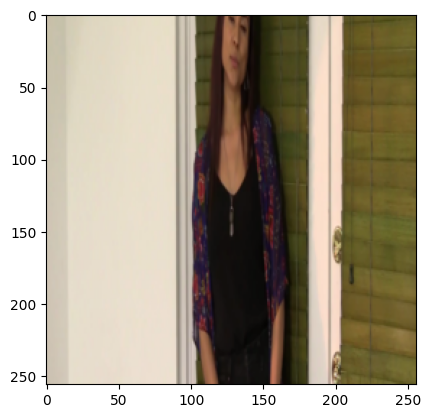

In [78]:
video, label, ID = experimental_dataset[0]
img = video[0]

display_image(img)
print(label)
print(video.shape)

Et comment faire un resize

torch.Size([10, 3, 1080, 1920])


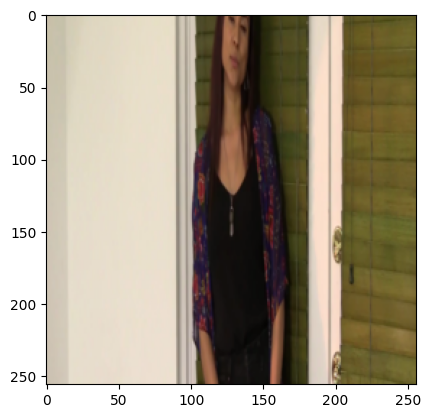

In [79]:
video, label, ID = experimental_dataset[0]
img=video[0]

img=smart_resize(img, 256)
#img[0]
display_image(img)

## Modèle

In [80]:
class DeepfakeDetector(nn.Module):
    def __init__(self, nb_frames=10, frame_size=256):
        super().__init__()
        self.dense = nn.Linear(nb_frames*3*frame_size*frame_size, 1)
        self.flat = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.flat(x)
        y = self.dense(y)
        y = self.sigmoid(y)
        return y


model = DeepfakeDetector(nb_frames=nb_frames)

video, label, ID = experimental_dataset[0]
video = video.unsqueeze(0) # add a batch dimension
summary(model, input_size=video.shape)

torch.Size([10, 3, 1080, 1920])


Layer (type:depth-idx)                   Output Shape              Param #
DeepfakeDetector                         [1, 1]                    --
├─Flatten: 1-1                           [1, 1966080]              --
├─Linear: 1-2                            [1, 1]                    1,966,081
├─Sigmoid: 1-3                           [1, 1]                    --
Total params: 1,966,081
Trainable params: 1,966,081
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.97
Input size (MB): 7.86
Forward/backward pass size (MB): 0.00
Params size (MB): 7.86
Estimated Total Size (MB): 15.73

## Logging

In [81]:
wandb.login(key="3e9fdd84fdda185e52cc6563bc7a14bbef429b90")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/me/.netrc


True

In [82]:
run = wandb.init(
    project="automathon",
    name="Noobs-Automathon-10",
    config={
        "learning_rate": 0.001,
        "architecture": "-",
        "dataset": "DeepFake Detection Challenge",
        "epochs": 10,
        "batch_size": 10,
    },
)

wandb: Currently logged in as: nicolas-guillard (nicogui). Use `wandb login --relogin` to force relogin


## Entrainement

In [83]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = get_best_device()

loss_fn = nn.MSELoss()
model = DeepfakeDetector().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
nb_epochs = 5
loader = DataLoader(experimental_dataset, batch_size=2, shuffle=True)

for epoch in range(nb_epochs):
    for sample in tqdm(loader, desc="Epoch {}".format(epoch), ncols=0):
        optimizer.zero_grad()
        
        X, label, ID = sample

        X = X.to(device)
        label = label.to(device)

        label_pred = model(X)
        label = torch.unsqueeze(label,dim=1)
        loss = loss_fn(label, label_pred)
        loss.backward()
        optimizer.step()

        run.log({"loss": loss.item(), "epoch": epoch})

MPS GPU available for training. Models moved to MPS GPU


Epoch 0:   0% 0/51 [00:00<?, ?it/s]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:   2% 1/51 [00:03<03:02,  3.66s/it]

torch.Size([10, 3, 1080, 1920])


Epoch 0:   4% 2/51 [00:06<02:29,  3.05s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:   6% 3/51 [00:08<02:10,  2.72s/it]

torch.Size([10, 3, 1280, 720])
torch.Size([10, 3, 1080, 1920])


Epoch 0:   8% 4/51 [00:11<02:04,  2.65s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  10% 5/51 [00:13<02:00,  2.62s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  12% 6/51 [00:16<01:58,  2.63s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  14% 7/51 [00:18<01:41,  2.31s/it]

torch.Size([10, 3, 1280, 720])
torch.Size([10, 3, 1920, 1080])


Epoch 0:  16% 8/51 [00:20<01:46,  2.47s/it]

torch.Size([10, 3, 1280, 720])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  18% 9/51 [00:23<01:43,  2.47s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 0:  20% 10/51 [00:25<01:42,  2.50s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  22% 11/51 [00:28<01:41,  2.53s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 0:  24% 12/51 [00:30<01:36,  2.47s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  25% 13/51 [00:33<01:36,  2.54s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  27% 14/51 [00:36<01:39,  2.69s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  29% 15/51 [00:38<01:30,  2.51s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 0:  31% 16/51 [00:41<01:34,  2.69s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 0:  33% 17/51 [00:44<01:33,  2.76s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 0:  35% 18/51 [00:47<01:33,  2.84s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  37% 19/51 [00:50<01:31,  2.86s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  39% 20/51 [00:53<01:25,  2.75s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  41% 21/51 [00:55<01:20,  2.69s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  43% 22/51 [00:58<01:16,  2.63s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  45% 23/51 [01:00<01:15,  2.69s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  47% 24/51 [01:03<01:11,  2.66s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  49% 25/51 [01:06<01:10,  2.70s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  51% 26/51 [01:08<01:06,  2.65s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 0:  53% 27/51 [01:11<01:03,  2.66s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  55% 28/51 [01:14<01:03,  2.78s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  57% 29/51 [01:17<00:59,  2.70s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 0:  59% 30/51 [01:20<00:58,  2.79s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  61% 31/51 [01:22<00:55,  2.79s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 0:  63% 32/51 [01:25<00:52,  2.75s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  65% 33/51 [01:28<00:48,  2.72s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 0:  67% 34/51 [01:30<00:45,  2.67s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  69% 35/51 [01:33<00:41,  2.57s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  71% 36/51 [01:35<00:38,  2.58s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  73% 37/51 [01:38<00:36,  2.62s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  75% 38/51 [01:41<00:35,  2.71s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  76% 39/51 [01:43<00:31,  2.63s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  78% 40/51 [01:46<00:28,  2.61s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  80% 41/51 [01:49<00:26,  2.63s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  82% 42/51 [01:51<00:23,  2.61s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  84% 43/51 [01:54<00:21,  2.66s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  86% 44/51 [01:56<00:18,  2.58s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  88% 45/51 [01:59<00:15,  2.52s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  90% 46/51 [02:01<00:12,  2.57s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  92% 47/51 [02:04<00:10,  2.56s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  94% 48/51 [02:07<00:07,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  96% 49/51 [02:09<00:05,  2.51s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0:  98% 50/51 [02:11<00:02,  2.50s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 0: 100% 51/51 [02:13<00:00,  2.62s/it]
Epoch 1:   0% 0/51 [00:00<?, ?it/s]

torch.Size([10, 3, 1080, 1920])


Epoch 1:   2% 1/51 [00:02<01:56,  2.32s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1280, 720])


Epoch 1:   4% 2/51 [00:04<01:41,  2.07s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 1:   6% 3/51 [00:07<01:56,  2.42s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:   8% 4/51 [00:09<01:55,  2.45s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  10% 5/51 [00:12<02:00,  2.61s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  12% 6/51 [00:15<01:59,  2.66s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 1:  14% 7/51 [00:18<02:01,  2.76s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  16% 8/51 [00:21<02:01,  2.84s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  18% 9/51 [00:23<01:56,  2.76s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1280, 720])


Epoch 1:  20% 10/51 [00:26<01:47,  2.62s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  22% 11/51 [00:29<01:51,  2.79s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  24% 12/51 [00:31<01:44,  2.68s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  25% 13/51 [00:35<01:49,  2.88s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  27% 14/51 [00:37<01:40,  2.72s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  29% 15/51 [00:39<01:36,  2.69s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 1:  31% 16/51 [00:42<01:35,  2.72s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  33% 17/51 [00:45<01:30,  2.66s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  35% 18/51 [00:47<01:27,  2.66s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  37% 19/51 [00:50<01:23,  2.61s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  39% 20/51 [00:53<01:24,  2.71s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  41% 21/51 [00:55<01:19,  2.64s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  43% 22/51 [00:58<01:14,  2.58s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  45% 23/51 [01:01<01:15,  2.69s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 1:  47% 24/51 [01:04<01:14,  2.76s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  49% 25/51 [01:06<01:10,  2.72s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  51% 26/51 [01:09<01:06,  2.64s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  53% 27/51 [01:11<01:01,  2.55s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  55% 28/51 [01:14<00:59,  2.57s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  57% 29/51 [01:17<00:58,  2.64s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  59% 30/51 [01:19<00:56,  2.68s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  61% 31/51 [01:22<00:51,  2.57s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 1:  63% 32/51 [01:24<00:49,  2.62s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  65% 33/51 [01:27<00:46,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 1:  67% 34/51 [01:30<00:45,  2.69s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 1:  69% 35/51 [01:33<00:44,  2.76s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 1:  71% 36/51 [01:35<00:40,  2.68s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  73% 37/51 [01:38<00:36,  2.63s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  75% 38/51 [01:41<00:35,  2.70s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 1:  76% 39/51 [01:43<00:31,  2.67s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  78% 40/51 [01:46<00:29,  2.66s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  80% 41/51 [01:48<00:25,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  82% 42/51 [01:51<00:23,  2.65s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  84% 43/51 [01:54<00:21,  2.66s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  86% 44/51 [01:56<00:17,  2.54s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 1:  88% 45/51 [01:59<00:15,  2.54s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  90% 46/51 [02:01<00:12,  2.53s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  92% 47/51 [02:04<00:10,  2.51s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 1:  94% 48/51 [02:06<00:07,  2.55s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1280, 720])


Epoch 1:  96% 49/51 [02:08<00:04,  2.39s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 1:  98% 50/51 [02:11<00:02,  2.47s/it]

torch.Size([10, 3, 1080, 1920])


Epoch 1: 100% 51/51 [02:12<00:00,  2.60s/it]


torch.Size([10, 3, 1080, 1920])


Epoch 2:   0% 0/51 [00:00<?, ?it/s]

torch.Size([10, 3, 1080, 1920])


Epoch 2:   2% 1/51 [00:02<02:04,  2.48s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:   4% 2/51 [00:04<01:48,  2.21s/it]

torch.Size([10, 3, 1280, 720])
torch.Size([10, 3, 1080, 1920])


Epoch 2:   6% 3/51 [00:07<01:57,  2.45s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:   8% 4/51 [00:09<02:00,  2.57s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  10% 5/51 [00:12<02:00,  2.61s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 2:  12% 6/51 [00:15<01:59,  2.65s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 2:  14% 7/51 [00:18<02:03,  2.81s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  16% 8/51 [00:21<01:58,  2.75s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  18% 9/51 [00:23<01:44,  2.48s/it]

torch.Size([10, 3, 1280, 720])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  20% 10/51 [00:25<01:45,  2.58s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  22% 11/51 [00:28<01:42,  2.57s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  24% 12/51 [00:31<01:42,  2.64s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  25% 13/51 [00:33<01:37,  2.57s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  27% 14/51 [00:35<01:32,  2.50s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 2:  29% 15/51 [00:38<01:33,  2.58s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  31% 16/51 [00:41<01:29,  2.56s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  33% 17/51 [00:44<01:30,  2.65s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  35% 18/51 [00:45<01:19,  2.40s/it]

torch.Size([10, 3, 1280, 720])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  37% 19/51 [00:48<01:17,  2.43s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  39% 20/51 [00:51<01:17,  2.49s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 2:  41% 21/51 [00:53<01:15,  2.52s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  43% 22/51 [00:56<01:14,  2.58s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 2:  45% 23/51 [00:58<01:11,  2.56s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  47% 24/51 [01:01<01:07,  2.50s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  49% 25/51 [01:03<01:05,  2.50s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 2:  51% 26/51 [01:06<01:03,  2.53s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  53% 27/51 [01:09<01:06,  2.76s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  55% 28/51 [01:12<01:01,  2.66s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  57% 29/51 [01:14<00:58,  2.65s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  59% 30/51 [01:17<00:56,  2.71s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  61% 31/51 [01:19<00:51,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  63% 32/51 [01:22<00:49,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  65% 33/51 [01:24<00:44,  2.48s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  67% 34/51 [01:27<00:42,  2.51s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  69% 35/51 [01:29<00:40,  2.54s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  71% 36/51 [01:32<00:37,  2.53s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  73% 37/51 [01:35<00:36,  2.62s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  75% 38/51 [01:38<00:35,  2.72s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  76% 39/51 [01:41<00:33,  2.80s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  78% 40/51 [01:43<00:30,  2.80s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  80% 41/51 [01:46<00:27,  2.77s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  82% 42/51 [01:49<00:24,  2.75s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  84% 43/51 [01:52<00:22,  2.79s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 2:  86% 44/51 [01:55<00:20,  2.87s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  88% 45/51 [01:57<00:16,  2.76s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  90% 46/51 [02:00<00:13,  2.65s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  92% 47/51 [02:02<00:10,  2.66s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  94% 48/51 [02:05<00:07,  2.61s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  96% 49/51 [02:08<00:05,  2.65s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 2:  98% 50/51 [02:10<00:02,  2.64s/it]

torch.Size([10, 3, 1080, 1920])


Epoch 2: 100% 51/51 [02:12<00:00,  2.60s/it]


torch.Size([10, 3, 1920, 1080])


Epoch 3:   0% 0/51 [00:00<?, ?it/s]

torch.Size([10, 3, 1080, 1920])


Epoch 3:   2% 1/51 [00:01<01:33,  1.87s/it]

torch.Size([10, 3, 1280, 720])
torch.Size([10, 3, 1080, 1920])


Epoch 3:   4% 2/51 [00:04<02:01,  2.48s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:   6% 3/51 [00:07<01:56,  2.43s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:   8% 4/51 [00:09<01:59,  2.54s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  10% 5/51 [00:12<01:56,  2.52s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1280, 720])


Epoch 3:  12% 6/51 [00:14<01:42,  2.27s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  14% 7/51 [00:16<01:44,  2.37s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  16% 8/51 [00:19<01:45,  2.46s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  18% 9/51 [00:22<01:45,  2.52s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  20% 10/51 [00:24<01:42,  2.51s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  22% 11/51 [00:26<01:37,  2.44s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  24% 12/51 [00:29<01:43,  2.65s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  25% 13/51 [00:32<01:38,  2.58s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  27% 14/51 [00:35<01:38,  2.67s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 3:  29% 15/51 [00:37<01:33,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  31% 16/51 [00:39<01:27,  2.50s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1280, 720])


Epoch 3:  33% 17/51 [00:41<01:18,  2.32s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  35% 18/51 [00:44<01:20,  2.45s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  37% 19/51 [00:47<01:18,  2.46s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  39% 20/51 [00:49<01:16,  2.47s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  41% 21/51 [00:52<01:14,  2.50s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  43% 22/51 [00:55<01:19,  2.76s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1920, 1080])


Epoch 3:  45% 23/51 [00:58<01:18,  2.81s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  47% 24/51 [01:01<01:17,  2.86s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  49% 25/51 [01:03<01:12,  2.79s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  51% 26/51 [01:06<01:05,  2.64s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  53% 27/51 [01:09<01:05,  2.74s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  55% 28/51 [01:11<01:00,  2.63s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  57% 29/51 [01:14<00:58,  2.68s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  59% 30/51 [01:16<00:53,  2.56s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  61% 31/51 [01:19<00:50,  2.52s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 3:  63% 32/51 [01:22<00:52,  2.75s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  65% 33/51 [01:24<00:47,  2.67s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 3:  67% 34/51 [01:27<00:45,  2.67s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  69% 35/51 [01:29<00:41,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  71% 36/51 [01:32<00:39,  2.62s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  73% 37/51 [01:35<00:36,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  75% 38/51 [01:37<00:34,  2.62s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  76% 39/51 [01:40<00:31,  2.66s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  78% 40/51 [01:42<00:28,  2.56s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  80% 41/51 [01:45<00:25,  2.51s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  82% 42/51 [01:48<00:23,  2.63s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  84% 43/51 [01:50<00:20,  2.58s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  86% 44/51 [01:53<00:18,  2.61s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  88% 45/51 [01:55<00:15,  2.55s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 3:  90% 46/51 [01:58<00:13,  2.64s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  92% 47/51 [02:01<00:10,  2.61s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  94% 48/51 [02:03<00:07,  2.57s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 3:  96% 49/51 [02:06<00:05,  2.65s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 3:  98% 50/51 [02:09<00:02,  2.63s/it]

torch.Size([10, 3, 1080, 1920])


Epoch 3: 100% 51/51 [02:10<00:00,  2.55s/it]


torch.Size([10, 3, 1080, 1920])


Epoch 4:   0% 0/51 [00:00<?, ?it/s]

torch.Size([10, 3, 1080, 1920])


Epoch 4:   2% 1/51 [00:02<02:09,  2.60s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 4:   4% 2/51 [00:04<02:01,  2.47s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:   6% 3/51 [00:07<01:54,  2.39s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:   8% 4/51 [00:09<01:57,  2.50s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  10% 5/51 [00:12<01:49,  2.39s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  12% 6/51 [00:15<01:57,  2.62s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  14% 7/51 [00:17<01:54,  2.60s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 4:  16% 8/51 [00:20<01:56,  2.70s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  18% 9/51 [00:23<01:51,  2.67s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  20% 10/51 [00:25<01:48,  2.65s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  22% 11/51 [00:28<01:45,  2.63s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  24% 12/51 [00:30<01:40,  2.57s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 4:  25% 13/51 [00:33<01:38,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  27% 14/51 [00:36<01:35,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 4:  29% 15/51 [00:38<01:34,  2.61s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 4:  31% 16/51 [00:41<01:30,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  33% 17/51 [00:43<01:26,  2.54s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  35% 18/51 [00:46<01:22,  2.49s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  37% 19/51 [00:48<01:19,  2.48s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  39% 20/51 [00:50<01:15,  2.44s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  41% 21/51 [00:53<01:14,  2.50s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  43% 22/51 [00:56<01:13,  2.54s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  45% 23/51 [00:58<01:11,  2.54s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  47% 24/51 [01:01<01:09,  2.58s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  49% 25/51 [01:03<00:59,  2.29s/it]

torch.Size([10, 3, 1280, 720])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  51% 26/51 [01:06<01:03,  2.56s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  53% 27/51 [01:08<01:02,  2.61s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  55% 28/51 [01:11<00:59,  2.59s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  57% 29/51 [01:14<00:58,  2.66s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1920, 1080])


Epoch 4:  59% 30/51 [01:17<00:58,  2.77s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  61% 31/51 [01:19<00:54,  2.73s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  63% 32/51 [01:22<00:49,  2.62s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  65% 33/51 [01:24<00:46,  2.58s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1280, 720])


Epoch 4:  67% 34/51 [01:26<00:41,  2.45s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  69% 35/51 [01:29<00:38,  2.41s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  71% 36/51 [01:31<00:36,  2.45s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  73% 37/51 [01:34<00:36,  2.59s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  75% 38/51 [01:37<00:33,  2.57s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  76% 39/51 [01:39<00:30,  2.58s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  78% 40/51 [01:41<00:25,  2.34s/it]

torch.Size([10, 3, 1280, 720])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  80% 41/51 [01:44<00:24,  2.43s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  82% 42/51 [01:46<00:21,  2.38s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  84% 43/51 [01:49<00:19,  2.44s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  86% 44/51 [01:51<00:17,  2.49s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  88% 45/51 [01:54<00:15,  2.55s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  90% 46/51 [01:57<00:12,  2.58s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  92% 47/51 [01:59<00:10,  2.62s/it]

torch.Size([10, 3, 1920, 1080])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  94% 48/51 [02:02<00:07,  2.55s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  96% 49/51 [02:05<00:05,  2.69s/it]

torch.Size([10, 3, 1080, 1920])
torch.Size([10, 3, 1080, 1920])


Epoch 4:  98% 50/51 [02:07<00:02,  2.66s/it]

torch.Size([10, 3, 1080, 1920])


Epoch 4: 100% 51/51 [02:09<00:00,  2.53s/it]

torch.Size([10, 3, 1080, 1920])


## Test

In [ ]:

loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
model = model.to(device)
ids = []
labels = []
print("Testing...")
for sample in tqdm(loader):
    X, ID = sample
    #ID = ID[0]
    X = X.to(device)
    label_pred = model(X)
    ids.extend(list(ID))
    pred = (label_pred > 0.5).long()
    pred = pred.cpu().detach().numpy().tolist()
    labels.extend(pred)


### Saving

In [ ]:
print("Saving...")
tests = ["id,label\n"] + [f"{ID},{label_pred[0]}\n" for ID, label_pred in zip(ids, labels)]
with open("submission.csv", "w") as file:
    file.writelines(tests)
